## From last notebook, where we get the raw data from 2020-01-01 to 2021-03-31, we cleaned up the dataset by keeping the rows that have "bbl", right time frame (2020-03-15 -- 2021-03-21), only keeping the relevant complaint types, and many other tiny basic cleaning procedures.

## In this notebook, our goal is to see, during this period, if any complaint types have strong correlations with evictions

### Hypothesis 1: 

The buildings that have more 'COVID-19 Non-essential Construction' complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 2:

The buildings that have more noise (any-type) complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 3: 

The buildings that have more water leak complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 4: 

The buildings that have more Appliance complaints had more evictions during 2020-03-15 -- 2021-03-21.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### As covid has passed for a while, this short study is not to examine what covid does to the relationships between landlord behavior and 311 complaints. Rather, only during covid, 311 complaints collected data on noise related to non-essentail constructions. Therefore, that period of time, March 2021 to March 2022 was a good time windown to look into how the non-essential construction noise might relate to unfriendly landloard behaviors.

#### The date of the data here is only from 2020 March to 2021 March.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# introducing filtered_df_covid data

file_path = '/content/drive/My Drive/X999/filtered_df_covid_period_all.csv'

In [39]:
covid_geo_df_raw = pd.read_csv(file_path)

In [40]:
# make a copy
covid_geo_df = covid_geo_df_raw.copy()

In [41]:
# already done in previous notebook
# covid_geo_df.created_date = pd.to_datetime(covid_geo_df.created_date)

In [42]:
# covid_geo_df.closed_date = pd.to_datetime(covid_geo_df.closed_date)

In [43]:
covid_geo_df.created_date.min(), covid_geo_df.created_date.max(), \
covid_geo_df.closed_date.min(), covid_geo_df.closed_date.max()

(Timestamp('2020-03-15 00:00:08'),
 Timestamp('2021-03-30 23:58:10'),
 Timestamp('2019-07-18 00:00:00'),
 Timestamp('2024-09-16 00:00:00'))

In [44]:
covid_geo_df.shape, \
covid_geo_df.info(), \
covid_geo_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408464 entries, 0 to 1408463
Data columns (total 23 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   unique_key                      1408464 non-null  int64         
 1   created_date                    1408464 non-null  datetime64[ns]
 2   closed_date                     1399522 non-null  datetime64[ns]
 3   complaint_type                  1408464 non-null  object        
 4   descriptor                      1393854 non-null  object        
 5   location_type                   1282878 non-null  object        
 6   incident_zip                    1408441 non-null  float64       
 7   incident_address                1408464 non-null  object        
 8   street_name                     1408464 non-null  object        
 9   cross_street_1                  858397 non-null   object        
 10  cross_street_2                  858432 non

((1408464, 23),
 None,
          unique_key                   created_date  \
 count  1.408464e+06                        1408464   
 mean   4.774781e+07  2020-09-23 10:34:11.115528960   
 min    2.233307e+07            2020-03-15 00:00:08   
 25%    4.667072e+07            2020-06-28 21:41:35   
 50%    4.761929e+07            2020-09-18 21:17:54   
 75%    4.844113e+07            2020-12-17 23:20:47   
 max    6.020556e+07            2021-03-30 23:58:10   
 std    1.267310e+06                            NaN   
 
                          closed_date  incident_zip           bbl  \
 count                        1399522  1.408441e+06  1.408464e+06   
 mean   2020-10-04 11:19:53.048551424  1.069966e+04  2.444138e+09   
 min              2019-07-18 00:00:00  8.300000e+01  0.000000e+00   
 25%    2020-07-04 00:33:57.249999872  1.030600e+04  2.024210e+09   
 50%              2020-09-24 00:00:00  1.046600e+04  2.048330e+09   
 75%              2020-12-28 08:55:37  1.122200e+04  3.051710e+09 

In [10]:
# since we particularly have an interest in "Non-Essentail Covid Consturction noise" that was only
# present during covid, we particularly set the timeframe as 2020-03-15 to 2021-03-31
# already didd this step in previous notebook
# filtered_df = covid_geo_df[covid_geo_df['created_date'] > pd.Timestamp('2020-03-15 00:00:00')]

In [45]:
filtered_df = covid_geo_df.copy()
filtered_df.shape, \
filtered_df.info(), \
filtered_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408464 entries, 0 to 1408463
Data columns (total 23 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   unique_key                      1408464 non-null  int64         
 1   created_date                    1408464 non-null  datetime64[ns]
 2   closed_date                     1399522 non-null  datetime64[ns]
 3   complaint_type                  1408464 non-null  object        
 4   descriptor                      1393854 non-null  object        
 5   location_type                   1282878 non-null  object        
 6   incident_zip                    1408441 non-null  float64       
 7   incident_address                1408464 non-null  object        
 8   street_name                     1408464 non-null  object        
 9   cross_street_1                  858397 non-null   object        
 10  cross_street_2                  858432 non

((1408464, 23),
 None,
          unique_key                   created_date  \
 count  1.408464e+06                        1408464   
 mean   4.774781e+07  2020-09-23 10:34:11.115528960   
 min    2.233307e+07            2020-03-15 00:00:08   
 25%    4.667072e+07            2020-06-28 21:41:35   
 50%    4.761929e+07            2020-09-18 21:17:54   
 75%    4.844113e+07            2020-12-17 23:20:47   
 max    6.020556e+07            2021-03-30 23:58:10   
 std    1.267310e+06                            NaN   
 
                          closed_date  incident_zip           bbl  \
 count                        1399522  1.408441e+06  1.408464e+06   
 mean   2020-10-04 11:19:53.048551424  1.069966e+04  2.444138e+09   
 min              2019-07-18 00:00:00  8.300000e+01  0.000000e+00   
 25%    2020-07-04 00:33:57.249999872  1.030600e+04  2.024210e+09   
 50%              2020-09-24 00:00:00  1.046600e+04  2.048330e+09   
 75%              2020-12-28 08:55:37  1.122200e+04  3.051710e+09 

In [46]:
filtered_df.complaint_type.unique()

array(['Noise - Commercial', 'Noise - Residential',
       'Noise - Street/Sidewalk', 'HEAT/HOT WATER',
       'UNSANITARY CONDITION', 'WATER LEAK', 'Noise', 'DOOR/WINDOW',
       'Indoor Air Quality', 'Noise - Vehicle', 'Elevator',
       'Noise - House of Worship', 'FLOORING/STAIRS', 'Graffiti',
       'PLUMBING', 'Rodent', 'SAFETY', 'Non-Emergency Police Matter',
       'Noise - Park', 'Smoking', 'Noise - Helicopter', 'ELECTRIC',
       'PAINT/PLASTER', 'Unsanitary Pigeon Condition',
       'General Construction/Plumbing', 'APPLIANCE', 'Indoor Sewage',
       'Animal-Abuse', 'GENERAL', 'Unsanitary Animal Pvt Property',
       'Mold', 'ELEVATOR', 'Construction Lead Dust', 'OUTSIDE BUILDING',
       'Plumbing', 'Non-Residential Heat', 'Posting Advertisement',
       'Asbestos', 'Homeless Street Condition', 'Collection Truck Noise',
       'Urinating in Public', 'Panhandling', 'Homeless Person Assistance',
       'Drinking', 'Disorderly Youth', 'Drinking Water',
       'Illegal Firewor

In [47]:
# introduce evictions data
file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [48]:
evictions_df_raw = pd.read_csv(file_path)

In [74]:
evictions_df_raw.executed_date = pd.to_datetime(evictions_df_raw.executed_date)

In [75]:
evictions_df_raw.executed_date.min(), evictions_df_raw.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-09-16 00:00:00'))

In [76]:
# attempted to filter out only the covid times
filtered_evictions_df = evictions_df_raw[
    (evictions_df_raw['executed_date'] >= '2020-03-15') &
    (evictions_df_raw['executed_date'] <= '2021-03-31')
]

In [81]:
# because the data is sooo few, I would still use all the eictions data from 2017-01-03 and 2024-09-16 to
# see if there is any correlations between evictions and complaint types.
filtered_evictions_df

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
30134,49319/19,13188,4327B BOYD AVENUE - GROUND FLOOR,GROUND FL,2020-12-03,BRONX,10466,Not an Ejectment,Possession,40.895919,-73.851522,12.0,12.0,436.0,2128086.0,2.050490e+09,Woodlawn-Wakefield
32151,51497/19,78147,11 MERSEREAU AVE.,STUDIO,2020-12-11,STATEN ISLAND,10303,Not an Ejectment,Possession,40.638516,-74.163452,1.0,49.0,31902.0,5141885.0,5.012380e+09,Mariner's Harbor-Arlington-Port Ivory-Granitev...
45587,67409/19,26110,98-59 CORONA AVENUE,3F,2020-11-30,QUEENS,11368,Not an Ejectment,Possession,40.744757,-73.863343,4.0,21.0,413.0,4462803.0,4.016290e+09,Corona
46061,67975/19,19711,87 EAST 53RD STREET,1C,2020-12-14,BROOKLYN,11203,Not an Ejectment,Possession,40.658001,-73.928111,17.0,41.0,866.0,3100293.0,3.046230e+09,Rugby-Remsen Village
49317,71946/19,99474,446 OCEAN AVENUE,BASEMENT ROOM,2020-12-07,BROOKLYN,11226,Not an Ejectment,Possession,40.651830,-73.961356,14.0,40.0,50801.0,3346384.0,3.050800e+09,Flatbush
59075,94879/17,100662,130 9TH STREET,4L,2020-11-24,BROOKLYN,11215,Not an Ejectment,Possession,40.672398,-73.992978,6.0,39.0,121.0,3022205.0,3.010080e+09,Park Slope-Gowanus
71223,K88618/19,119029,250 ASHLAND PLACE,21H,2020-11-20,BROOKLYN,11217,Not an Ejectment,Possession,40.687723,-73.978336,2.0,35.0,33.0,3424470.0,3.021078e+09,Fort Greene
76336,R52067/19,102910,700 VICTORY BOULEVAR D,15F,2020-12-10,STATEN ISLAND,10301,Not an Ejectment,Possession,40.625527,-74.092492,1.0,49.0,39.0,5015146.0,5.005900e+09,Grymes Hill-Clifton-Fox Hills
76337,R52067/19B,102911,700 VICTORY BOULEVAR D,15F,2020-12-10,STATEN ISLAND,10301,Not an Ejectment,Possession,40.625527,-74.092492,1.0,49.0,39.0,5015146.0,5.005900e+09,Grymes Hill-Clifton-Fox Hills


In [80]:
# good to know, but would still use all the data.
filtered_evictions_df.shape

(9, 17)

In [50]:
# make a copy
evictions_df = evictions_df_raw.copy()

In [83]:
# much more data and satisfy the gaussian distribution rule
evictions_df.shape

(76484, 17)

In [51]:
evictions_df.shape, \
evictions_df.info(), \
evictions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76484 entries, 0 to 76483
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   court_index_number         76484 non-null  object 
 1   docket_number              76484 non-null  int64  
 2   eviction_address           76484 non-null  object 
 3   eviction_apartment_number  76484 non-null  object 
 4   executed_date              76484 non-null  object 
 5   borough                    76484 non-null  object 
 6   eviction_postcode          76484 non-null  int64  
 7   ejectment                  76484 non-null  object 
 8   eviction/legal_possession  76484 non-null  object 
 9   latitude                   76484 non-null  float64
 10  longitude                  76484 non-null  float64
 11  community_board            76484 non-null  float64
 12  council_district           76484 non-null  float64
 13  census_tract               76484 non-null  flo

((76484, 17),
 None,
        docket_number  eviction_postcode      latitude     longitude  \
 count   76484.000000       76484.000000  76484.000000  76484.000000   
 mean   143989.257021       10777.686850     40.751630    -73.910286   
 std    139761.773310         505.847601      0.092530      0.068949   
 min         1.000000       10000.000000     40.499050    -74.251262   
 25%     38859.000000       10454.000000     40.670288    -73.945326   
 50%     96911.000000       10470.000000     40.754527    -73.910906   
 75%    170319.500000       11226.000000     40.837296    -73.874795   
 max    496987.000000       11698.000000     40.912869    -73.701430   
 
        community_board  council_district   census_tract           bin  \
 count     76484.000000      76484.000000   76484.000000  7.648400e+04   
 mean          8.020593         24.111278    8567.369045  2.709656e+06   
 std           4.587810         13.877776   21448.949314  1.114210e+06   
 min           1.000000          

In [52]:
evictions_df.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [53]:
filtered_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'status', 'resolution_description',
       'resolution_action_updated_date', 'bbl', 'borough', 'latitude',
       'longitude', 'location'],
      dtype='object')

In [55]:
# just take one example to check (rather randomly)
truck_noise = filtered_df[filtered_df['complaint_type'] == 'Noise - Street/Sidewalk']
truck_noise.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,address_type,city,status,resolution_description,resolution_action_updated_date,bbl,borough,latitude,longitude,location
14,45823101,2020-03-15 00:04:31,2020-03-15 03:06:39,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11366.0,160-30 75 ROAD,75 ROAD,160 STREET,...,NaN,FRESH MEADOWS,Closed,The Police Department responded to the complai...,03/15/2020 03:06:42 AM,4.068350e+09,QUEENS,40.726060,-73.808267,"(40.7260601826664, -73.80826721990762)"
19,45827945,2020-03-15 00:07:19,2020-05-23 10:54:28,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11377.0,47-05 45 STREET,45 STREET,47 AVENUE,...,NaN,WOODSIDE,Closed,The Police Department reviewed your complaint ...,05/23/2020 10:54:30 AM,4.001700e+09,QUEENS,40.740929,-73.920082,"(40.740928673179084, -73.92008243952031)"
24,45822708,2020-03-15 00:07:55,2020-03-15 00:23:41,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11229.0,1815 EAST 17 STREET,EAST 17 STREET,AVENUE R,...,NaN,BROOKLYN,Closed,Your request can not be processed at this time...,03/15/2020 12:24:04 AM,3.068210e+09,BROOKLYN,40.605587,-73.955754,"(40.605586570194475, -73.95575378891145)"
27,45829807,2020-03-15 00:08:38,2020-03-15 07:14:59,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11105.0,20-01 27 STREET,27 STREET,20 AVENUE,...,NaN,ASTORIA,Closed,The Police Department responded to the complai...,03/15/2020 07:15:02 AM,4.008590e+09,QUEENS,40.781202,-73.908898,"(40.78120224242657, -73.90889823547073)"
30,45824884,2020-03-15 00:09:02,2020-03-15 00:29:48,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,10472.0,1207 BEACH AVENUE,BEACH AVENUE,GLEASON AVENUE,...,NaN,BRONX,Closed,The Police Department responded to the complai...,03/15/2020 12:29:56 AM,2.037630e+09,BRONX,40.830362,-73.866022,"(40.83036235589997, -73.86602154214397)"


In [56]:
filtered_df.complaint_type.unique()

array(['Noise - Commercial', 'Noise - Residential',
       'Noise - Street/Sidewalk', 'HEAT/HOT WATER',
       'UNSANITARY CONDITION', 'WATER LEAK', 'Noise', 'DOOR/WINDOW',
       'Indoor Air Quality', 'Noise - Vehicle', 'Elevator',
       'Noise - House of Worship', 'FLOORING/STAIRS', 'Graffiti',
       'PLUMBING', 'Rodent', 'SAFETY', 'Non-Emergency Police Matter',
       'Noise - Park', 'Smoking', 'Noise - Helicopter', 'ELECTRIC',
       'PAINT/PLASTER', 'Unsanitary Pigeon Condition',
       'General Construction/Plumbing', 'APPLIANCE', 'Indoor Sewage',
       'Animal-Abuse', 'GENERAL', 'Unsanitary Animal Pvt Property',
       'Mold', 'ELEVATOR', 'Construction Lead Dust', 'OUTSIDE BUILDING',
       'Plumbing', 'Non-Residential Heat', 'Posting Advertisement',
       'Asbestos', 'Homeless Street Condition', 'Collection Truck Noise',
       'Urinating in Public', 'Panhandling', 'Homeless Person Assistance',
       'Drinking', 'Disorderly Youth', 'Drinking Water',
       'Illegal Firewor

In [57]:
covid_construction_complaints_df = filtered_df[filtered_df['complaint_type'] == 'COVID-19 Non-essential Construction']
covid_construction_complaints_df.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,address_type,city,status,resolution_description,resolution_action_updated_date,bbl,borough,latitude,longitude,location
37461,45917428,2020-03-30 15:17:55,2020-04-03,COVID-19 Non-essential Construction,Construction,NaN,11210.0,2701 GLENWOOD ROAD,GLENWOOD ROAD,NaN,...,ADDRESS,BROOKLYN,Closed,The Department of Buildings investigated this ...,04/03/2020 12:00:00 AM,3.052480e+09,BROOKLYN,40.633721,-73.950752,"(40.63372140221787, -73.95075236485184)"
42251,46053078,2020-04-01 18:48:42,2020-04-02,COVID-19 Non-essential Construction,Construction,NaN,10003.0,57 ST MARKS PLACE,ST MARKS PLACE,NaN,...,ADDRESS,NEW YORK,Closed,The Department of Buildings investigated this ...,04/02/2020 12:00:00 AM,1.004500e+09,MANHATTAN,40.728149,-73.986586,"(40.7281485993278, -73.98658554747719)"
42365,46052090,2020-04-01 19:54:49,2020-04-04,COVID-19 Non-essential Construction,Construction,NaN,10028.0,1622 YORK AVENUE,YORK AVENUE,NaN,...,ADDRESS,NEW YORK,Closed,The Department of Buildings investigated this ...,04/04/2020 12:00:00 AM,1.015820e+09,MANHATTAN,40.775605,-73.947347,"(40.77560500339383, -73.9473473957807)"
42433,46006412,2020-04-01 20:34:08,2020-06-07,COVID-19 Non-essential Construction,Construction,NaN,11219.0,1202 TABOR COURT,TABOR COURT,NaN,...,ADDRESS,BROOKLYN,Closed,The Department of Buildings investigated this ...,06/07/2020 12:00:00 AM,3.057320e+09,BROOKLYN,40.628539,-74.001859,"(40.62853879370961, -74.0018589366503)"
42509,46056574,2020-04-01 21:07:16,2020-04-02,COVID-19 Non-essential Construction,Construction,NaN,10451.0,702 GRAND CONCOURSE,GRAND CONCOURSE,NaN,...,ADDRESS,BRONX,Closed,The Department of Buildings investigated this ...,04/02/2020 12:00:00 AM,0.000000e+00,BRONX,40.821959,-73.925141,"(40.82195941362754, -73.92514096620819)"


In [58]:
covid_complaint_count = covid_construction_complaints_df.groupby('bbl').size().reset_index(name='covid_complaint_count')


In [59]:
covid_complaint_count.head()

,bbl,covid_complaint_count
0,0.000000e+00,21
1,1.000020e+09,2
2,1.000048e+09,3
3,1.000110e+09,1
4,1.000110e+09,1


In [60]:
eviction_count = evictions_df.groupby('bbl').size().reset_index(name='eviction_count')
eviction_count.head()

,bbl,eviction_count
0,0.000000e+00,3
1,1.000078e+09,2
2,1.000158e+09,4
3,1.000158e+09,3
4,1.000160e+09,2


In [61]:
merged_df = covid_complaint_count.merge(eviction_count, on='bbl', how='inner')
merged_df.head()

,bbl,covid_complaint_count,eviction_count
0,0.000000e+00,21,3
1,1.000168e+09,1,1
2,1.000170e+09,5,9
3,1.000238e+09,4,1
4,1.000260e+09,1,2


In [62]:
# not high correlation
correlation = merged_df['covid_complaint_count'].corr(merged_df['eviction_count'])
print(f"Correlation between COVID-19 Non-essential Construction complaints and evictions: {correlation}")

Correlation between COVID-19 Non-essential Construction complaints and evictions: 0.05757959262408502


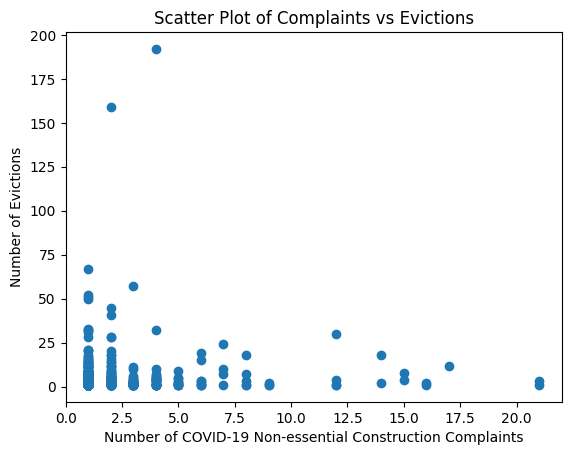

In [63]:
import matplotlib.pyplot as plt

plt.scatter(merged_df['covid_complaint_count'], merged_df['eviction_count'])
plt.xlabel('Number of COVID-19 Non-essential Construction Complaints')
plt.ylabel('Number of Evictions')
plt.title('Scatter Plot of Complaints vs Evictions')
plt.show()

# no strong correlation

In [67]:
# checkout the relationship between other complaint types and the evictions data:
covid_complaints_count = covid_geo_df.groupby(['bbl', 'complaint_type']).size().reset_index(name='complaint_count')

In [68]:
eviction_count = evictions_df.groupby('bbl').size().reset_index(name='eviction_count')

In [69]:
merged_df = covid_complaints_count.merge(eviction_count, on='bbl', how='inner')

In [42]:
# unique_complaints = merged_df['complaint_type'].unique()
# correlations = {}

# for complaint in unique_complaints:
#     # each complaint type
#     complaint_df = merged_df[merged_df['complaint_type'] == complaint]
#     # correlation
#     # not calculating correlation on a single data point
#     if len(complaint_df) > 1:
#         correlation = complaint_df['complaint_count'].corr(complaint_df['eviction_count'])
#         correlations[complaint] = correlation


In [70]:
# using dict directly, better for sorting the values
dict_of_correlations = {}

unique_complaints = merged_df['complaint_type'].unique()

for complaint in unique_complaints:
    # each complaint type (each type stands alone as a df)
    complaint_df = merged_df[merged_df['complaint_type'] == complaint]
    if len(complaint_df) > 1:
        correlation = complaint_df['complaint_count'].corr(complaint_df['eviction_count'])
        dict_of_correlations[complaint] = correlation

In [71]:
# sort
sorted_correlations = dict(sorted(dict_of_correlations.items(), key=lambda item: item[1], reverse=False))

for complaint_type, correlation in sorted_correlations.items():
    print(f"complaint type: {complaint_type}, correlation with evictions: {correlation}")

complaint type: Mold, correlation with evictions: -0.11042149485988659
complaint type: Harboring Bees/Wasps, correlation with evictions: -0.10733905371285886
complaint type: Bike/Roller/Skate Chronic, correlation with evictions: -0.09910606116337602
complaint type: Homeless Person Assistance, correlation with evictions: -0.09647682190516033
complaint type: Peeling Paint, correlation with evictions: -0.09444939350931644
complaint type: Window Guard, correlation with evictions: -0.09379580992210836
complaint type: Standing Water, correlation with evictions: -0.09346312068209639
complaint type: Collection Truck Noise, correlation with evictions: -0.053665364049882446
complaint type: Graffiti, correlation with evictions: -0.04210217377550392
complaint type: Drinking, correlation with evictions: -0.037749335564177505
complaint type: Plumbing, correlation with evictions: -0.035039192093787995
complaint type: OUTSIDE BUILDING, correlation with evictions: -0.0341363076237609
complaint type: No

## conclusion:
The top 5 most correlated:  \

complaint type: Day Care, correlation with evictions: 0.984057367453252 \
complaint type: Posting Advertisement, correlation with evictions: 0.9524850821144154 \
complaint type: Panhandling, correlation with evictions: 0.9098431565585486 \
complaint type: WATER LEAK, correlation with evictions: 0.45215453304219416 \
complaint type: APPLIANCE, correlation with evictions: 0.38966445546749745 \

## results: 

### Hypothesis 1: (False)

The buildings that have more 'COVID-19 Non-essential Construction' complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 2: (False)

The buildings that have more noise (any-type) complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 3: (True)

The buildings that have more water leak complaints had more evictions during 2020-03-15 -- 2021-03-21.

### Hypothesis 4: (True)

The buildings that have more Appliance complaints had more evictions during 2020-03-15 -- 2021-03-21.

